In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys , os

In [2]:
mnist = tf.keras.datasets.mnist

In [3]:
(x_train , y_train) , (x_test , y_test) = mnist.load_data()
x_train , x_test = x_train/255.0*2-1 , x_test/255.0*2-1

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
N, H ,  W = x_train.shape
D=H*W
x_train =x_train.reshape(-1 , D)
x_test =x_test.reshape(-1 , D)

In [6]:
latent_dim = 100

In [7]:
from tensorflow.keras.layers import Input , Dense , LeakyReLU , Dropout , BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD , Adam


In [8]:
def generator(latent_dim):
    i =Input(shape=(latent_dim , )) 
    x=Dense(256 , activation=LeakyReLU(alpha=0.2))(i)
    x=BatchNormalization(momentum=0.8)(x)
    x= Dense(512 , activation=LeakyReLU(alpha=0.2))(x)
    x=BatchNormalization(momentum=0.8)(x)
    x=Dense(1024 , activation=LeakyReLU(alpha=0.2))(i)
    x=BatchNormalization(momentum=0.8)(x)
    x=Dense(D , activation='tanh')(x)
    
    
    model = Model(i , x)
    return model

In [9]:
def img_discriminator(img_size):
    i=Input(shape=(img_size , ))
    x=Dense(512 , activation=LeakyReLU(alpha=0.2))(i)
    x=Dense(256 , activation=LeakyReLU(alpha=0.2))(x)
    x=Dense(1 , activation='sigmoid')(x)
    
    model=Model(i , x)
    return model

In [10]:
disc=img_discriminator(D)
disc.compile(loss='binary_crossentropy' , optimizer=Adam(0.0002 , 0.5) , metrics=['accuracy'])
gen = generator(latent_dim )

z=Input(shape=(latent_dim , ))
img = gen(z)
disc.trainable=False 
fake_pred = disc(img)

combined_model = Model(z , fake_pred)
combined_model.compile(optimizer=Adam(0.0002 , 0.5) , loss='binary_crossentropy' , metrics=['accuracy']) 
    

C:\Users\Sparsh Mahajan\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [11]:
batch = 32 
epochs = 5000
period=200


In [12]:
ones = np.ones(batch)
zeros = np.zeros(batch)


In [13]:
d_losses=[] 
q_losses=[]

In [14]:
if not os.path.exists('gan_images'):
    os.makedirs('gan_Images')

In [15]:
def sample_images(epoch):
    rows , cols = 5 , 5
    noise = np.random.randn(rows*cols , latent_dim)
    imgs=gen.predict(noise)
    
    
    imgs=0.5*imgs+0.5
    fig , axs= plt.subplots(rows , cols)
    idx=0 
    for i in range(rows):
        for j in range(cols):
            axs[i , j].imshow(imgs[idx].reshape(H  ,W) , cmap='gray')
            axs[i , j].axis('off')
            idx+=1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

In [ ]:
for epoch in range(epochs):
    idx=np.random.randint(0 , x_train.shape[0] , batch)
    real_img = x_train[idx]
    
    noise = np.random.randn(batch , latent_dim)
    fake = gen.predict(noise)
    
    
    d_loss_real , d_acc_real = disc.train_on_batch(real_img , ones)
    d_loss_fake , d_acc_fake = disc.train_on_batch(fake , zeros)
    
    d_loss = 0.5*(d_loss_real + d_loss_fake) 
    d_acc = 0.5*(d_acc_real+d_acc_fake)
    
    
    #train 
    
    noise = np.random.randn(batch , latent_dim)
    q_loss = combined_model.train_on_batch(noise , ones)
    
    d_losses.append(d_loss)
    q_losses.append(q_loss)
    
    if epoch%100==0:
        print(d_loss)
        print(q_loss)
        
    if epoch%period==0:
        sample_images(epoch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


C:\Users\Sparsh Mahajan\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0.47924456000328064
[array(0.53655475, dtype=float32), array(0.53655475, dtype=float32), array(0.5, dtype=float32), array(0.5, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━

1/1 [==============================] - 0s 42ms/step
0.6781075298786163
[0.7640674114227295, 0.21875]
1/1 [==============================] - 0s 31ms/step
0.6437613666057587
[0.8333067893981934, 0.21875]
1/1 [==============================] - 0s 57ms/step
0.6743592917919159
[0.7381686568260193, 0.375]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 39ms/step


In [ ]:
plt.plot(q_losses)
plt.plot(d_losses)

In [19]:
gan_images

NameError: name 'gan_images' is not defined

C:\Users\Sparsh Mahajan\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


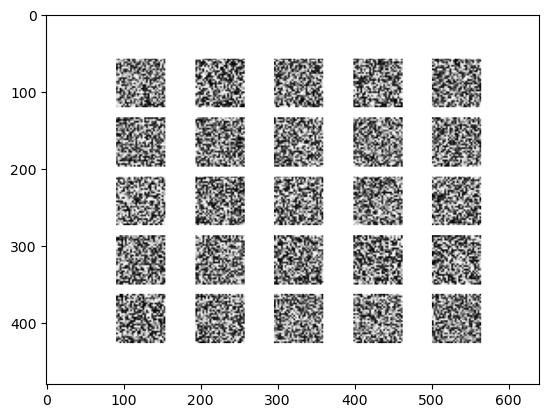

In [17]:
from skimage.io import imread
a = imread('gan_Images/5000.png')
plt.imshow(a)